In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from clickhouse_driver import Client
from statistics import mean

#connect
from connect import client

### Выгрзим нужные данные

In [3]:
print('В БД monitoring есть таблицы:')
print(client.execute('SHOW TABLES'))

В БД monitoring есть таблицы:
[('history',), ('history2',), ('history_nifi',), ('history_opt1',), ('history_opt2',)]


Мы будем работать с таблицей history

bytes_on_disk (UInt64) – общий размер всех файлов кусков данных в байтах.

data_compressed_bytes (UInt64) – общий размер сжатой информации в куске данных. Размер всех дополнительных файлов (например, файлов с засечками) не учитывается.

data_uncompressed_bytes (UInt64) – общий размер распакованной информации куска данных. Размер всех дополнительных файлов (например, файлов с засечками) не учитывается.

In [4]:
client.execute('''SELECT table , round(sum(data_compressed_bytes) /1024/1024/1024, 2) as size_gb
                FROM system.parts
                WHERE active
                GROUP BY table
                ORDER BY size_gb DESC''')

[('query_log', 118.71),
 ('query_thread_log', 104.74),
 ('history', 62.38),
 ('history_opt1', 17.05),
 ('history_opt2', 16.76),
 ('history2', 9.42),
 ('query_log_0', 6.68),
 ('query_thread_log_0', 6.0),
 ('metric_log', 3.04),
 ('metric_log_0', 0.47),
 ('trace_log', 0.26),
 ('asynchronous_metric_log', 0.1),
 ('readings', 0.0),
 ('crash_log', 0.0)]

Вес этой таблицы 62.13 ГБ, поэтому загрузить её всю в dataframe не получится.сначала визуализуруем её часть, чтобы лучше понять как выглядит эта таблица

In [5]:
result, column = client.execute("SELECT * FROM history LIMIT 1000",
                               with_column_types = True)

In [6]:
col = []
for c in column:
    col.append(c[0])

data = pd.DataFrame(result, columns=col)
data

,host,name,clock,value_str,value_int,value_float,ms
0,Mskmgt1325_Vityaz,lkviz_online,2020-10-17 03:00:00,,None,1.0,0
1,Mskmgt1209_Vityaz,lkviz_online,2020-10-17 03:00:00,,None,1.0,0
2,Mskmgt1253_Vityaz,pvi_online,2020-10-17 03:00:00,,None,1.0,0
3,Mskmgt1061_Vityaz,lkviz_online,2020-10-17 03:00:00,,None,1.0,0
4,Mskmgt1341_Vityaz,pvi_online,2020-10-17 03:00:00,,None,1.0,0
...,...,...,...,...,...,...,...
995,Mskmgt1314_Vityaz,lkviz_online,2020-10-17 03:00:28,,None,1.0,0
996,Mskmgt1049_Vityaz,online_tr,2020-10-17 03:00:28,,None,2.0,0
997,Mskmgt1151_Vityaz,online_tr,2020-10-17 03:00:28,,None,2.0,0
998,Mskmgt1058_Vityaz,online_tr,2020-10-17 03:00:28,,None,2.0,0


In [7]:
print(f"Таблица history начала заполняться с {data.clock.min()}")

Таблица history начала заполняться с 2020-10-17 03:00:00


In [8]:
cnt = client.execute('''select sum(data_compressed_bytes)/1024/1024 size, round((sum(data_uncompressed_bytes))/1024/1024) ub, sum(rows), partition, count() part_count, database,table
    FROM system.parts 
    where active = 1 and table like '%' and database like '%' 
    group by database,table, partition''')

##### Удалим ненужные таблицы

In [9]:
len(cnt)

902

In [10]:
indx = []
for i in range(len(cnt)):
    if 'monitoring' not in cnt[i] or 'history' not in cnt[i]:
        indx.append(i)

In [11]:
for i in range(len(indx)):
    cnt.pop(indx[i] - i)

In [12]:
len(cnt)

383

In [13]:
cnt

[(212.2736644744873, 1660.0, 35992426, '20210628', 4, 'monitoring', 'history'),
 (207.22973537445068,
  1788.0,
  38685305,
  '20210923',
  7,
  'monitoring',
  'history'),
 (278.05360889434814,
  1510.0,
  39259987,
  '20201023',
  3,
  'monitoring',
  'history'),
 (168.5541067123413, 1355.0, 29415061, '20210503', 4, 'monitoring', 'history'),
 (148.5323724746704, 1001.0, 26454961, '20210313', 3, 'monitoring', 'history'),
 (204.81422901153564,
  1730.0,
  37432333,
  '20211011',
  6,
  'monitoring',
  'history'),
 (153.55846691131592,
  1205.0,
  26154175,
  '20210717',
  5,
  'monitoring',
  'history'),
 (4.8502912521362305, 68.0, 1572480, '20210107', 1, 'monitoring', 'history'),
 (203.7477626800537, 1644.0, 35698808, '20210420', 4, 'monitoring', 'history'),
 (218.6510467529297, 1693.0, 36712769, '20210727', 3, 'monitoring', 'history'),
 (163.58085441589355,
  1323.0,
  28749313,
  '20210410',
  3,
  'monitoring',
  'history'),
 (162.04300498962402,
  1114.0,
  28453923,
  '20201130',

##### Вынесем размер БД

In [14]:
bd_size = []

for i in range(len(cnt)):
    bd_size.append(cnt[i][0])

bd_size

[212.2736644744873,
 207.22973537445068,
 278.05360889434814,
 168.5541067123413,
 148.5323724746704,
 204.81422901153564,
 153.55846691131592,
 4.8502912521362305,
 203.7477626800537,
 218.6510467529297,
 163.58085441589355,
 162.04300498962402,
 213.81815814971924,
 186.36906242370605,
 214.43219566345215,
 205.079909324646,
 218.92724895477295,
 216.2646369934082,
 225.95868968963623,
 213.1119842529297,
 160.38616180419922,
 152.21275901794434,
 224.88485622406006,
 181.38072967529297,
 202.37097930908203,
 53.21450138092041,
 156.8576078414917,
 1.401803970336914,
 144.71291637420654,
 157.85183715820312,
 0.16004562377929688,
 203.27069187164307,
 207.56662368774414,
 213.9869899749756,
 250.38094902038574,
 209.29601764678955,
 4.889523506164551,
 4.908228874206543,
 197.42871761322021,
 262.0088405609131,
 201.24020671844482,
 198.96547985076904,
 167.2586441040039,
 160.20353412628174,
 211.09990978240967,
 4.86769962310791,
 256.11662006378174,
 222.74213027954102,
 4.8599309

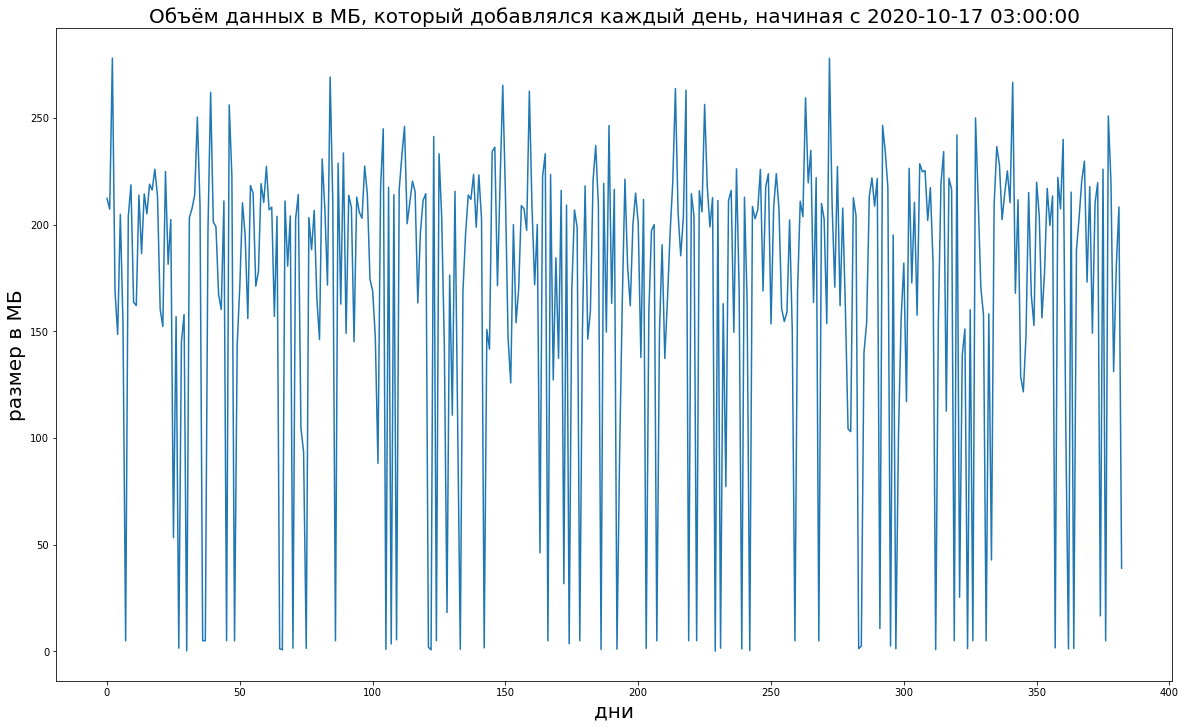

In [15]:
plt.figure(figsize = (20, 12))

plt.plot(range(383), bd_size)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"Объём данных в МБ, который добавлялся каждый день, начиная с {data.clock.min()}", fontsize = 20)

plt.show()

##### Теперь объединим данные и посмотрим на размер базы данных каждый день/неделю( рост объёма таблицы )

In [16]:
day = []
val = 0

for i in range(len(bd_size)):
    val += bd_size[i]
    day.append(val)

day

[212.2736644744873,
 419.503399848938,
 697.5570087432861,
 866.1111154556274,
 1014.6434879302979,
 1219.4577169418335,
 1373.0161838531494,
 1377.8664751052856,
 1581.6142377853394,
 1800.265284538269,
 1963.8461389541626,
 2125.8891439437866,
 2339.707302093506,
 2526.076364517212,
 2740.508560180664,
 2945.58846950531,
 3164.515718460083,
 3380.780355453491,
 3606.7390451431274,
 3819.851029396057,
 3980.2371912002563,
 4132.449950218201,
 4357.334806442261,
 4538.715536117554,
 4741.086515426636,
 4794.301016807556,
 4951.158624649048,
 4952.560428619385,
 5097.273344993591,
 5255.125182151794,
 5255.285227775574,
 5458.555919647217,
 5666.122543334961,
 5880.1095333099365,
 6130.490482330322,
 6339.786499977112,
 6344.676023483276,
 6349.584252357483,
 6547.012969970703,
 6809.021810531616,
 7010.262017250061,
 7209.22749710083,
 7376.486141204834,
 7536.689675331116,
 7747.789585113525,
 7752.657284736633,
 8008.773904800415,
 8231.516035079956,
 8236.375966072083,
 8380.2488145

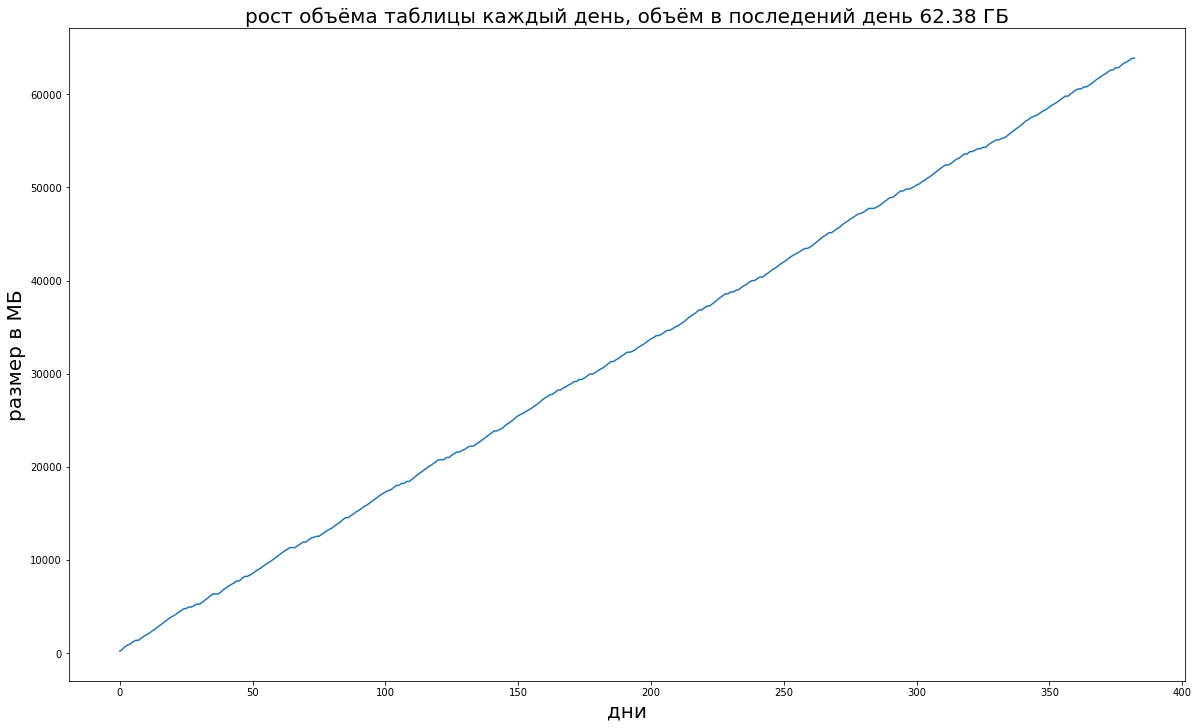

In [17]:
plt.figure(figsize = (20, 12))

plt.plot(range(383), day)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"рост объёма таблицы каждый день, объём в последений день {round(day[len(day) - 1]/1024, 2)} ГБ", fontsize = 20)

plt.show()

In [18]:
week = []

for i in range(0, len(day), 7):
    week.append(day[i])

week.append(63619.581464767456)

week

[212.2736644744873,
 1377.8664751052856,
 2740.508560180664,
 4132.449950218201,
 5097.273344993591,
 6339.786499977112,
 7376.486141204834,
 8380.248814582825,
 9716.668921470642,
 11123.687764167786,
 11926.4647397995,
 12934.202356338501,
 14331.301590919495,
 15534.268915176392,
 16951.00293827057,
 17993.204773902893,
 19128.200212478638,
 20546.05470943451,
 21446.036576271057,
 22217.459800720215,
 23653.23906326294,
 24791.61892414093,
 26117.897500038147,
 27544.526602745056,
 28602.230590820312,
 29554.272691726685,
 30639.612057685852,
 31922.5659866333,
 32962.35834026337,
 34090.779393196106,
 35129.513098716736,
 36568.57019805908,
 37681.61661815643,
 38779.835490226746,
 39992.04389953613,
 40988.14256858826,
 42410.20322227478,
 43448.75458717346,
 44909.99756240845,
 46190.28590106964,
 47325.77429866791,
 48253.30436325073,
 49614.481285095215,
 50369.85984039307,
 51815.472641944885,
 53026.07433414459,
 53987.70461368561,
 54937.31360912323,
 55974.60963821411,
 57

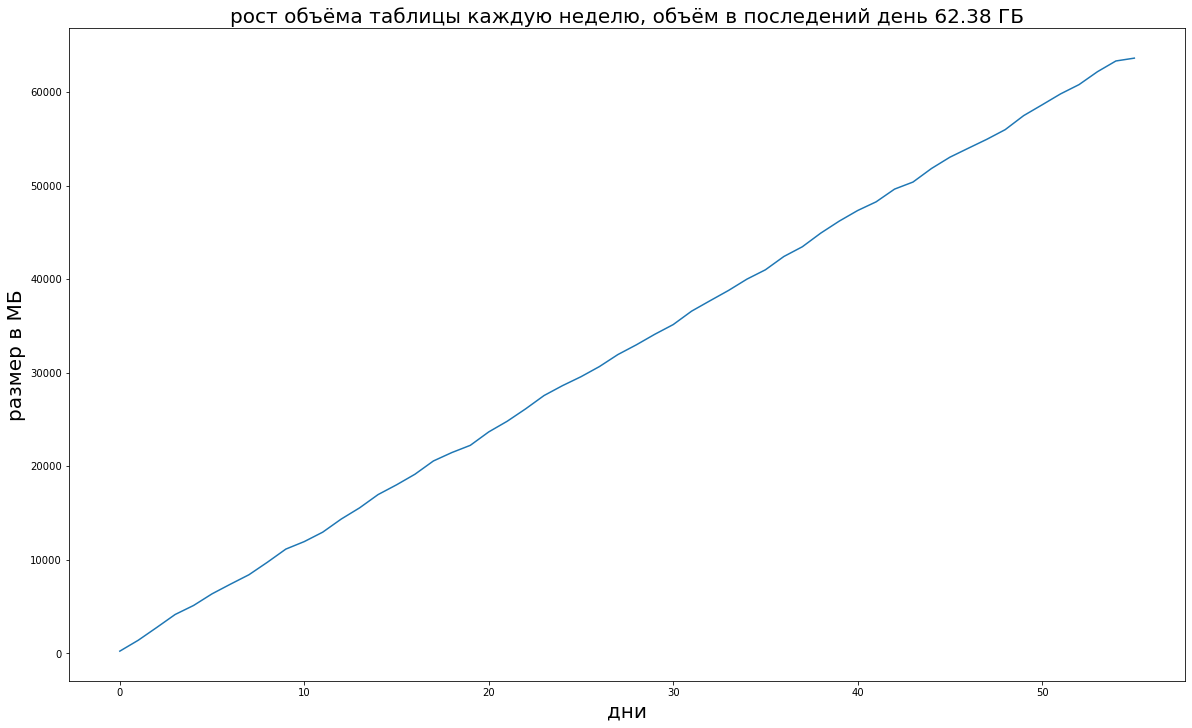

In [19]:
plt.figure(figsize = (20, 12))

plt.plot(range(len(week)), week)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"рост объёма таблицы каждую неделю, объём в последений день {round(day[len(day) - 1]/1024, 2)} ГБ", fontsize = 20)

plt.show()

### Посчитаем количество метрик(количество строк) за час в каждом месяцe, начиная с 2020-10-17 03:00:00

создам массив из дат, в котором будут даты с 2020-10-17 03:00:00 по сегодняшний момент с шагом в 1 час
первая дата: 2020-10-17 03:00:00
последняя дата: 2021-11-15 03:00:00

In [20]:
# import datetime, fromisoformat
from datetime import *
base = datetime.fromisoformat('2021-11-15 03:00:00')
date_list = [base - timedelta(hours=x) for x in range(9457)]
date_list

[datetime.datetime(2021, 11, 15, 3, 0),
 datetime.datetime(2021, 11, 15, 2, 0),
 datetime.datetime(2021, 11, 15, 1, 0),
 datetime.datetime(2021, 11, 15, 0, 0),
 datetime.datetime(2021, 11, 14, 23, 0),
 datetime.datetime(2021, 11, 14, 22, 0),
 datetime.datetime(2021, 11, 14, 21, 0),
 datetime.datetime(2021, 11, 14, 20, 0),
 datetime.datetime(2021, 11, 14, 19, 0),
 datetime.datetime(2021, 11, 14, 18, 0),
 datetime.datetime(2021, 11, 14, 17, 0),
 datetime.datetime(2021, 11, 14, 16, 0),
 datetime.datetime(2021, 11, 14, 15, 0),
 datetime.datetime(2021, 11, 14, 14, 0),
 datetime.datetime(2021, 11, 14, 13, 0),
 datetime.datetime(2021, 11, 14, 12, 0),
 datetime.datetime(2021, 11, 14, 11, 0),
 datetime.datetime(2021, 11, 14, 10, 0),
 datetime.datetime(2021, 11, 14, 9, 0),
 datetime.datetime(2021, 11, 14, 8, 0),
 datetime.datetime(2021, 11, 14, 7, 0),
 datetime.datetime(2021, 11, 14, 6, 0),
 datetime.datetime(2021, 11, 14, 5, 0),
 datetime.datetime(2021, 11, 14, 4, 0),
 datetime.datetime(2021, 1

Создадим функцию, которая будет создавать массив из количества метрик(строк) за каждый час за весь период

In [21]:
def metrics():
    all_metrics_in_hour = []
    
    for i in range(1, 9457):
        all_metrics_in_hour.append(client.execute(f"SELECT count() FROM history WHERE clock < '{date_list[len(date_list) - (i + 1)]}' AND clock >= '{date_list[len(date_list) - i]}'"))    
    
    return all_metrics_in_hour

Вывовем её и положим все метрики в список

In [22]:
%%time

all_metrics = metrics()

Wall time: 6min 7s


In [23]:
metric = []

for i in range(len(all_metrics)):
    metric.append(all_metrics[i][0])
    
metric

[(124232,),
 (368952,),
 (784204,),
 (1034662,),
 (1355736,),
 (1457004,),
 (1493244,),
 (1513662,),
 (1509557,),
 (1505373,),
 (1493547,),
 (1499771,),
 (1486266,),
 (1513101,),
 (1496111,),
 (1536645,),
 (1484431,),
 (1567461,),
 (1440069,),
 (1214075,),
 (1027923,),
 (873098,),
 (566287,),
 (237179,),
 (133566,),
 (375282,),
 (788796,),
 (1051043,),
 (1367561,),
 (1483978,),
 (1466379,),
 (1507665,),
 (1551895,),
 (1529125,),
 (1530908,),
 (1545732,),
 (1561330,),
 (1571789,),
 (1542384,),
 (1542487,),
 (1540509,),
 (1586359,),
 (1471081,),
 (1276868,),
 (1057351,),
 (888277,),
 (595924,),
 (265104,),
 (122016,),
 (339420,),
 (970696,),
 (1740418,),
 (2015936,),
 (2018198,),
 (2003152,),
 (2008911,),
 (1977031,),
 (1911221,),
 (1846784,),
 (1819327,),
 (1896913,),
 (2022264,),
 (2030324,),
 (2105196,),
 (2000820,),
 (2025672,),
 (1946683,),
 (1736829,),
 (1382919,),
 (1008479,),
 (627740,),
 (282319,),
 (131355,),
 (407090,),
 (1057656,),
 (1737063,),
 (1969608,),
 (1986076,),
 (196

In [24]:
date_list = date_list[::-1]

##### График метрик за все дни с периодом в час

1) График, где показано количество метрик за час

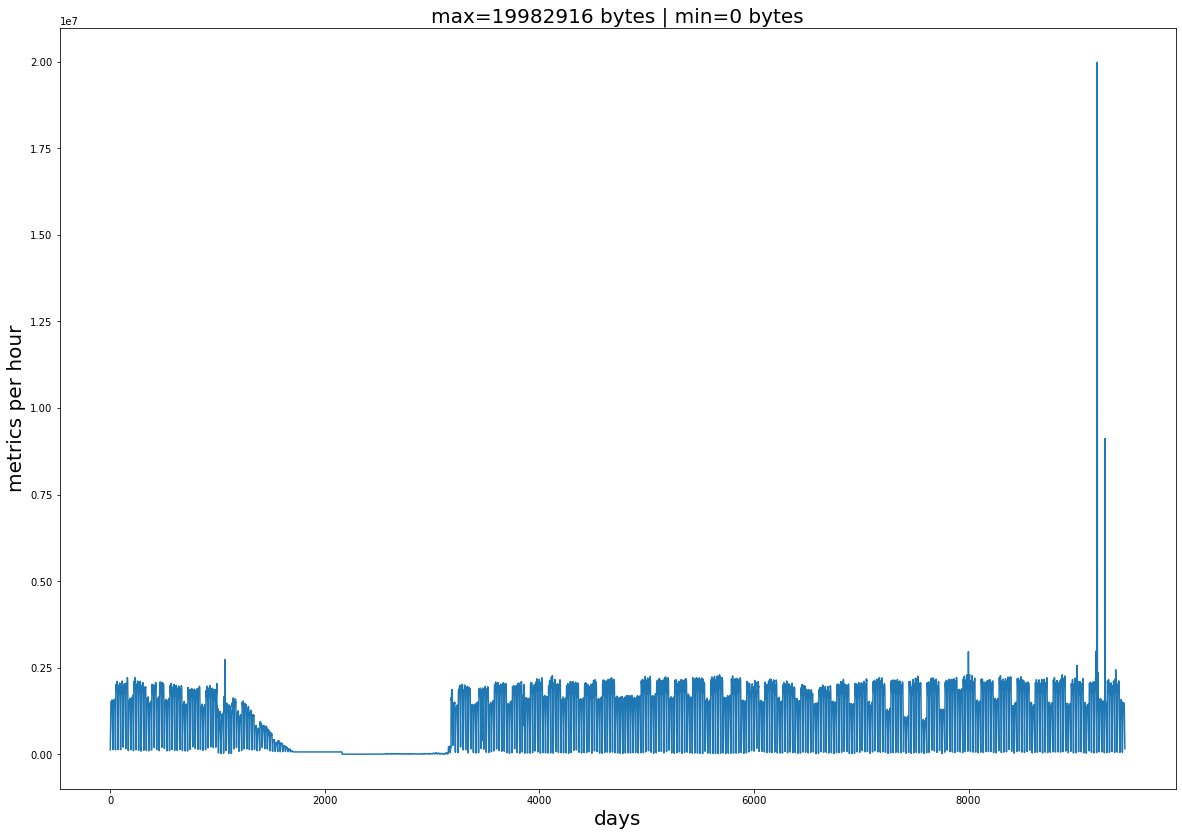

In [25]:
plt.figure(figsize = (20, 14))

plt.plot(range(1, len(metric) + 1), metric)
plt.xlabel("days", fontsize = 20)
plt.ylabel("metrics per hour", fontsize = 20)
plt.title(f"max={max(metric)[0]} bytes | min={min(metric)[0]} bytes", fontsize = 20)

plt.show()

2) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик за весь период

In [26]:
all_time_metrics = []
val = 0

for i in range(len(metric)):
    val += metric[i][0]
    all_time_metrics.append(val)

all_time_metrics

[124232,
 493184,
 1277388,
 2312050,
 3667786,
 5124790,
 6618034,
 8131696,
 9641253,
 11146626,
 12640173,
 14139944,
 15626210,
 17139311,
 18635422,
 20172067,
 21656498,
 23223959,
 24664028,
 25878103,
 26906026,
 27779124,
 28345411,
 28582590,
 28716156,
 29091438,
 29880234,
 30931277,
 32298838,
 33782816,
 35249195,
 36756860,
 38308755,
 39837880,
 41368788,
 42914520,
 44475850,
 46047639,
 47590023,
 49132510,
 50673019,
 52259378,
 53730459,
 55007327,
 56064678,
 56952955,
 57548879,
 57813983,
 57935999,
 58275419,
 59246115,
 60986533,
 63002469,
 65020667,
 67023819,
 69032730,
 71009761,
 72920982,
 74767766,
 76587093,
 78484006,
 80506270,
 82536594,
 84641790,
 86642610,
 88668282,
 90614965,
 92351794,
 93734713,
 94743192,
 95370932,
 95653251,
 95784606,
 96191696,
 97249352,
 98986415,
 100956023,
 102942099,
 104909618,
 106895635,
 108864600,
 110722188,
 112458042,
 114186862,
 116007704,
 117961555,
 120001002,
 122053018,
 124093710,
 126136173,
 128108

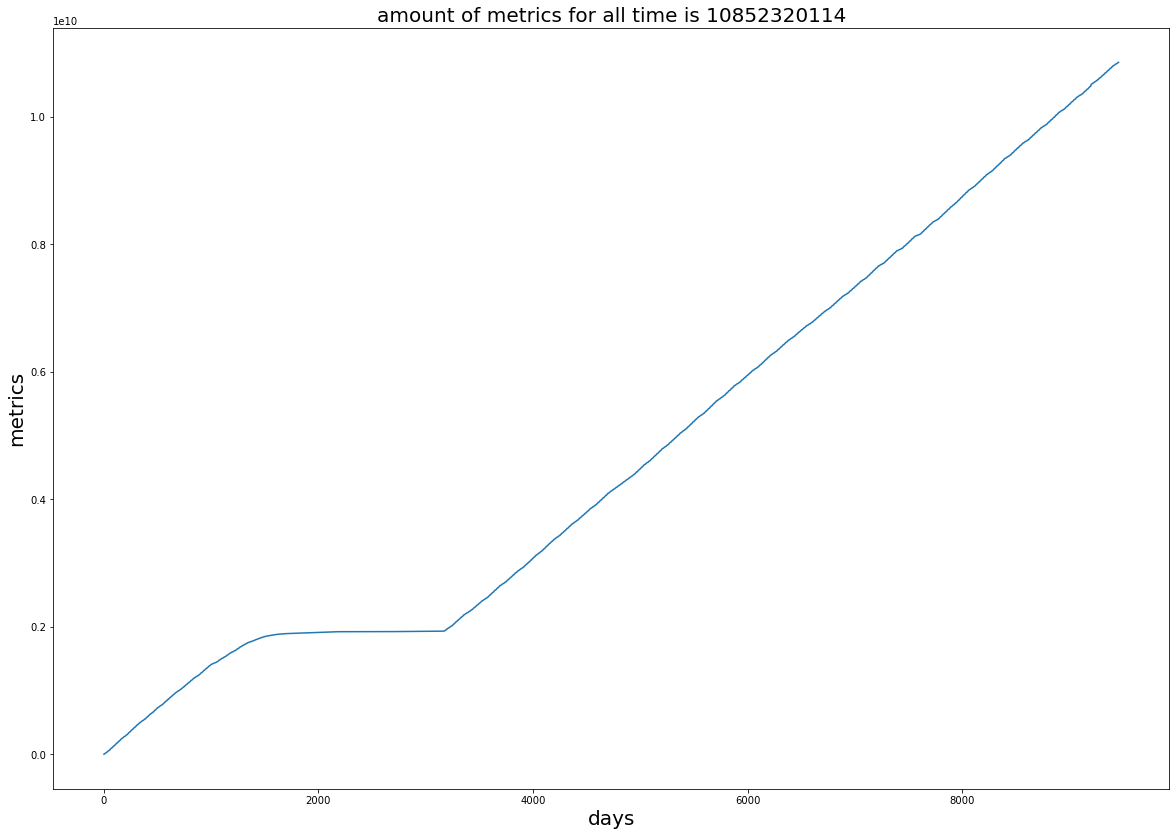

In [27]:
plt.figure(figsize = (20, 14))

plt.plot(range(1, len(metric) + 1), all_time_metrics)
plt.xlabel("days", fontsize = 20)
plt.ylabel("metrics", fontsize = 20)
plt.title(f"amount of metrics for all time is {all_time_metrics[len(all_time_metrics) - 1]}", fontsize = 20)

plt.show()

##### Создадим таблицу с метриками за каждый час за всё время

В ней показан период расчёта количество метрик

In [28]:
df_dict = {
    "from": date_list[:len(date_list)-1],
    "to": date_list[1:],
    "metrics": [val[0] for val in metric]
}

df = pd.DataFrame(df_dict)

df

,from,to,metrics
0,2020-10-17 03:00:00,2020-10-17 04:00:00,124232
1,2020-10-17 04:00:00,2020-10-17 05:00:00,368952
2,2020-10-17 05:00:00,2020-10-17 06:00:00,784204
3,2020-10-17 06:00:00,2020-10-17 07:00:00,1034662
4,2020-10-17 07:00:00,2020-10-17 08:00:00,1355736
...,...,...,...
9451,2021-11-14 22:00:00,2021-11-14 23:00:00,1104592
9452,2021-11-14 23:00:00,2021-11-15 00:00:00,928273
9453,2021-11-15 00:00:00,2021-11-15 01:00:00,744890
9454,2021-11-15 01:00:00,2021-11-15 02:00:00,496658


Вывод всех дней, когда metrics = 0

In [29]:
df.loc[df['metrics'] == 0]

,from,to,metrics
2160,2021-01-15 03:00:00,2021-01-15 04:00:00,0
2161,2021-01-15 04:00:00,2021-01-15 05:00:00,0
2162,2021-01-15 05:00:00,2021-01-15 06:00:00,0
2163,2021-01-15 06:00:00,2021-01-15 07:00:00,0
2164,2021-01-15 07:00:00,2021-01-15 08:00:00,0
...,...,...,...
2759,2021-02-09 02:00:00,2021-02-09 03:00:00,0
2760,2021-02-09 03:00:00,2021-02-09 04:00:00,0
2783,2021-02-10 02:00:00,2021-02-10 03:00:00,0
2784,2021-02-10 03:00:00,2021-02-10 04:00:00,0


##### Построим графики с размером метрик за каждый месяц

###### 1 вариант:
Пострим графики, где начало месяца будет считаться 17 число и 3 часа ночи, так как первая запись была 2020-10-17 03:00:00
Получается, что у нас будет не полный только последний месяц

###### 2 вариант:
Постром графики, где начала месяца будет соответствовать календарному началу месяца
Получается, что у нас будут 2 неполных месяца: первый и последний

##### Реализуем 1 вариант:

1) Создадим список с нужными датами

In [30]:
date_month = []

for i in range(len(date_list)):
    if date_list[i].strftime('%d%H') == '1703':
        date_month.append(date_list[i])

date_month.append(datetime.fromisoformat('2021-11-15 03:00:00'))

date_month

[datetime.datetime(2020, 10, 17, 3, 0),
 datetime.datetime(2020, 11, 17, 3, 0),
 datetime.datetime(2020, 12, 17, 3, 0),
 datetime.datetime(2021, 1, 17, 3, 0),
 datetime.datetime(2021, 2, 17, 3, 0),
 datetime.datetime(2021, 3, 17, 3, 0),
 datetime.datetime(2021, 4, 17, 3, 0),
 datetime.datetime(2021, 5, 17, 3, 0),
 datetime.datetime(2021, 6, 17, 3, 0),
 datetime.datetime(2021, 7, 17, 3, 0),
 datetime.datetime(2021, 8, 17, 3, 0),
 datetime.datetime(2021, 9, 17, 3, 0),
 datetime.datetime(2021, 10, 17, 3, 0),
 datetime.datetime(2021, 11, 15, 3, 0)]

2) посмтроим графики, где будет показано количество метрик за каждый час

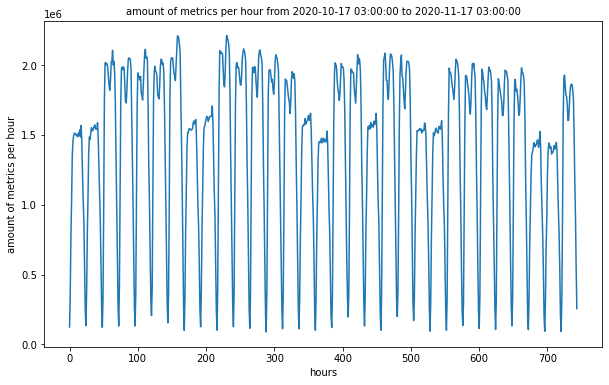

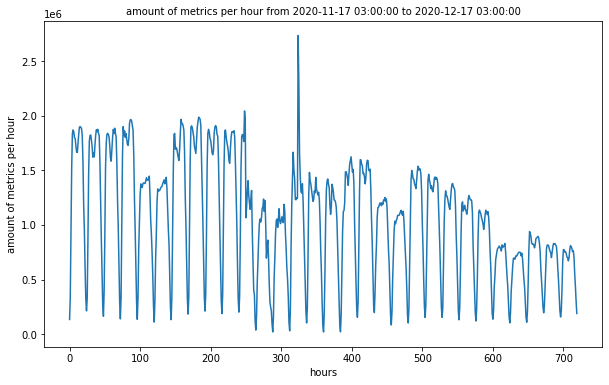

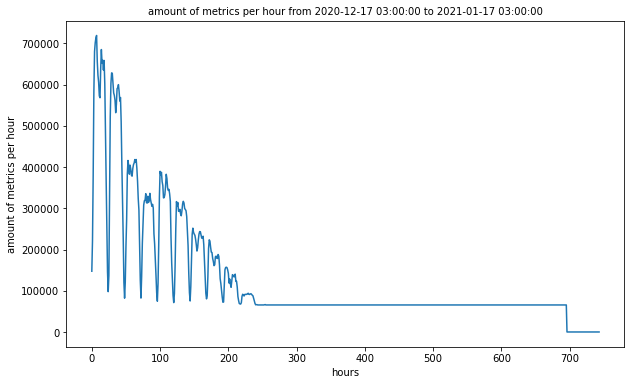

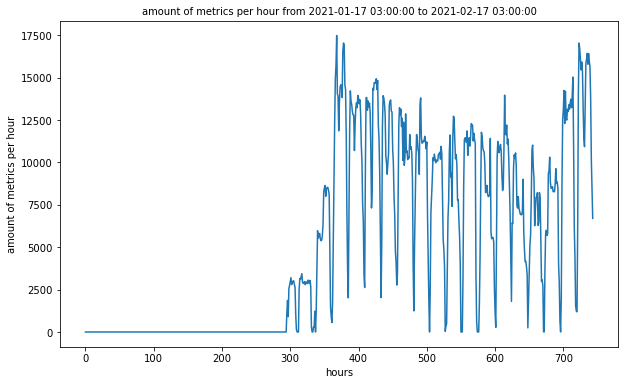

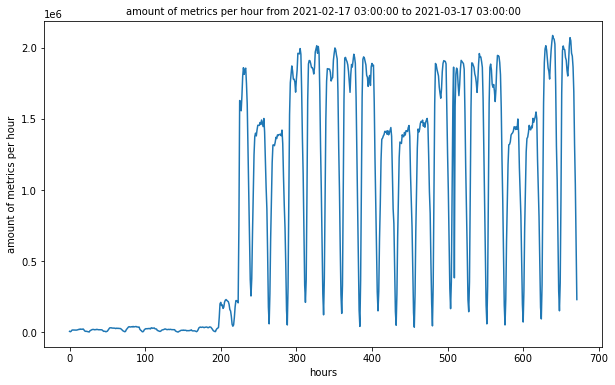

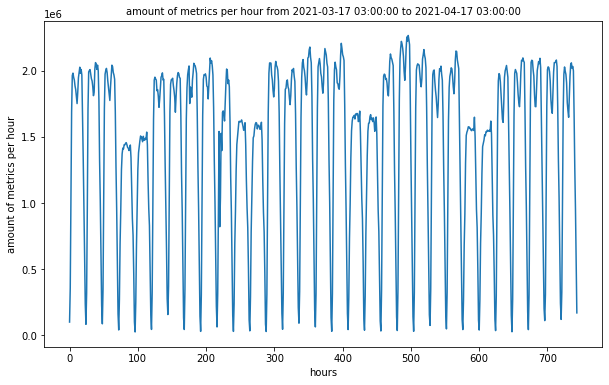

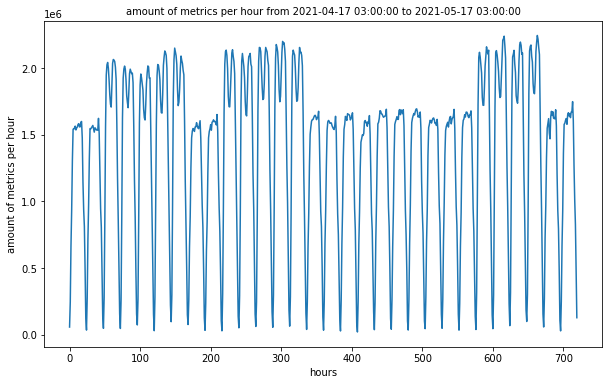

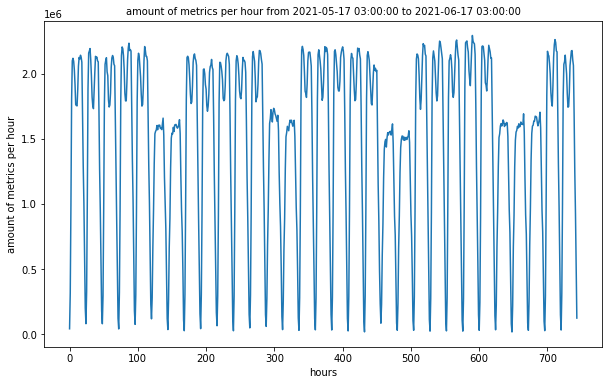

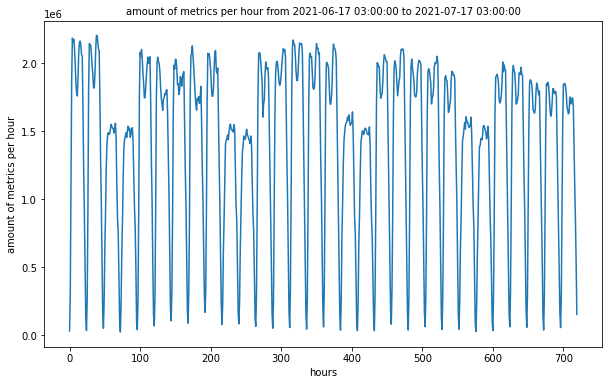

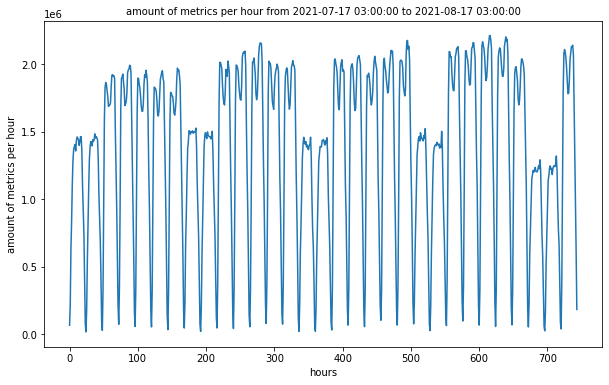

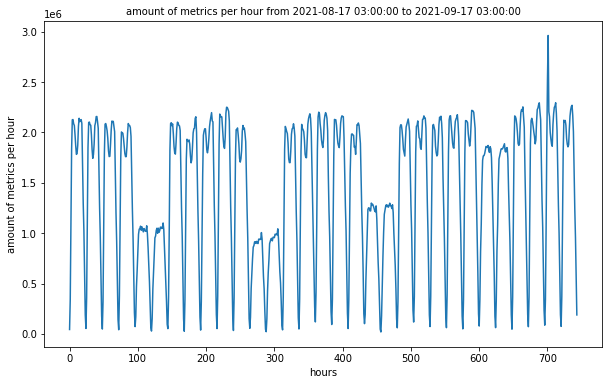

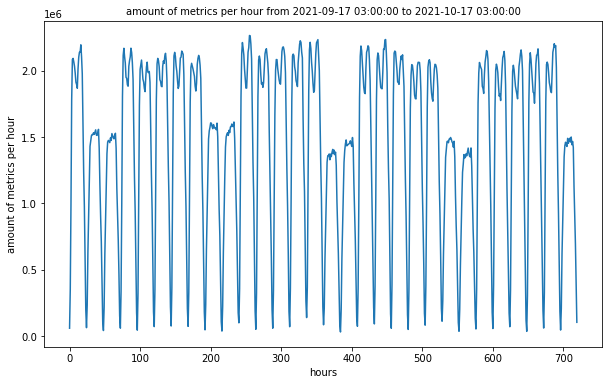

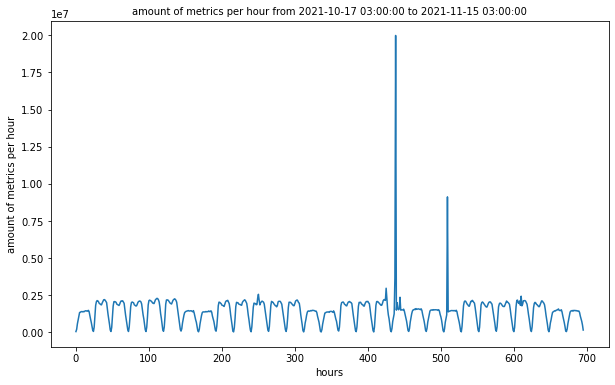

In [31]:
for i in range(len(date_month)):
    if i == 13:
        break
        
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month[i]) & (df['from'] < date_month[i+1])]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), X)
    plt.xlabel("hours", fontsize = 10)
    plt.ylabel(f"amount of metrics per hour", fontsize = 10)
    plt.title(f"amount of metrics per hour from {date_month[i]} to {date_month[i+1]}", fontsize = 10)
    
    plt.show()

3) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик в этом месяце

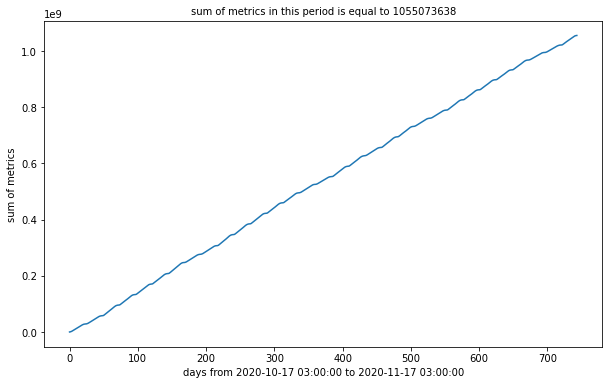

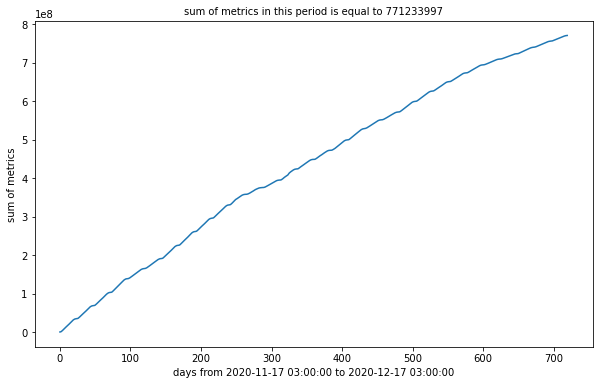

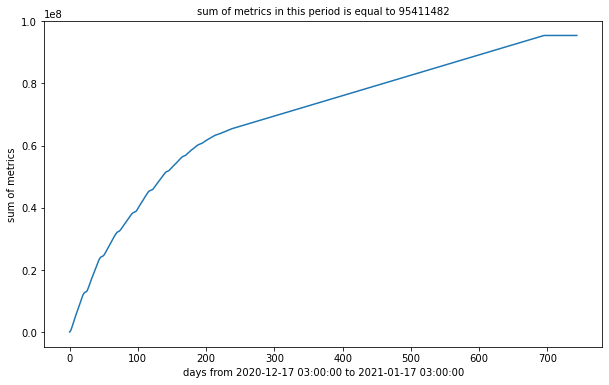

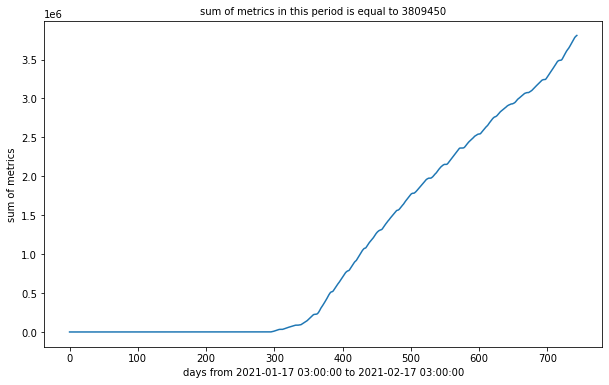

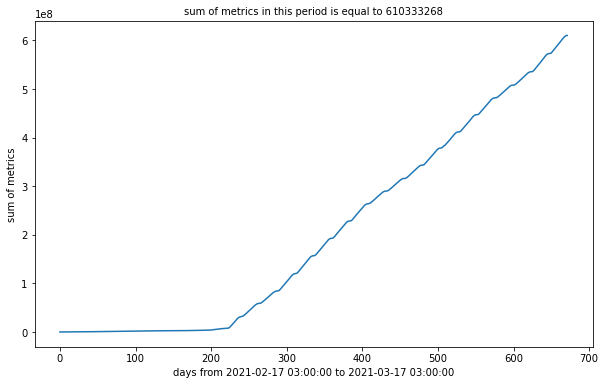

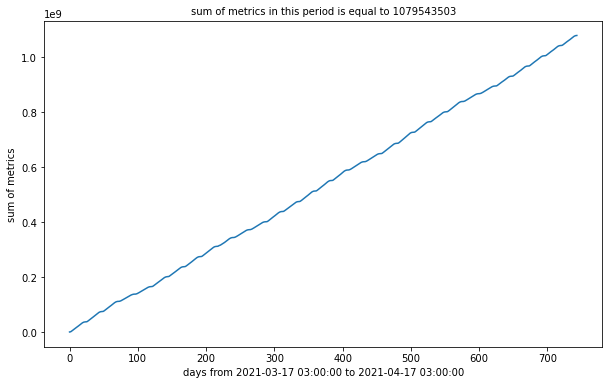

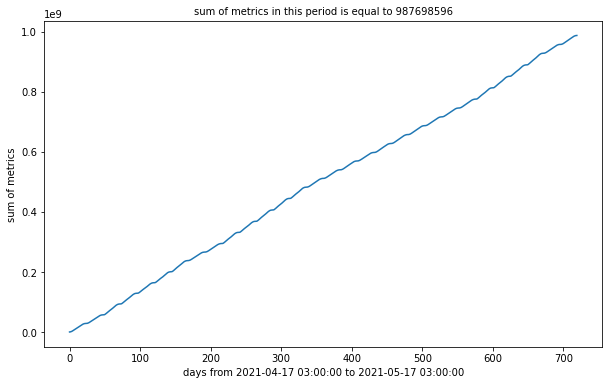

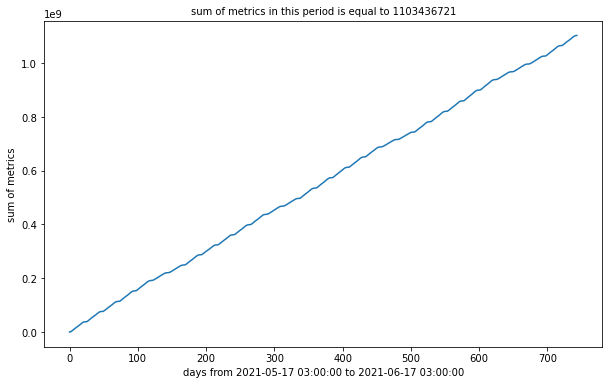

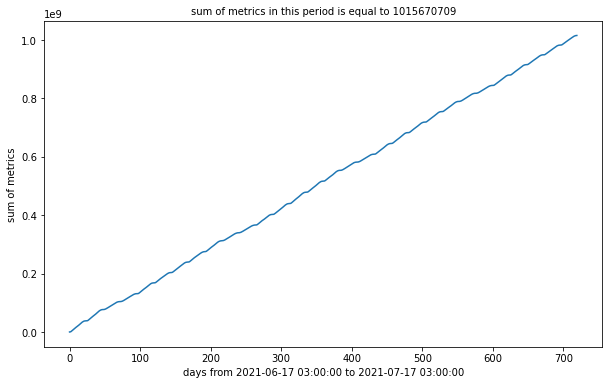

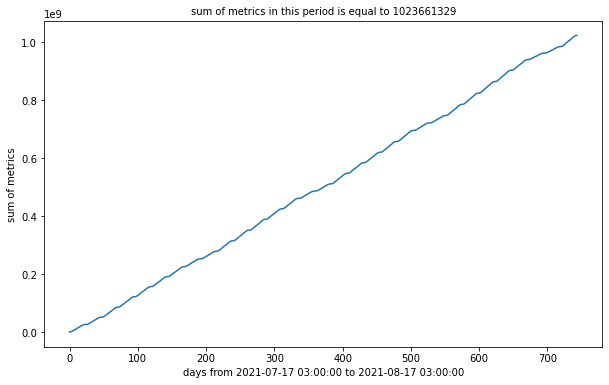

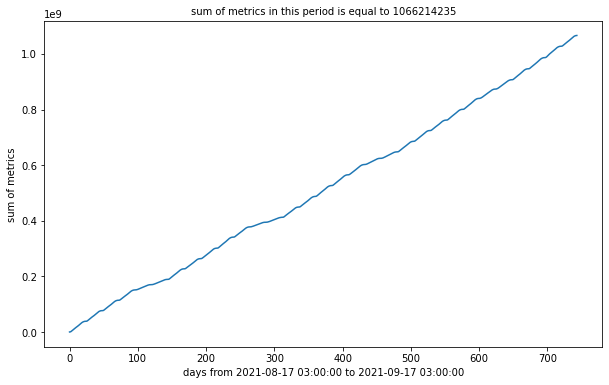

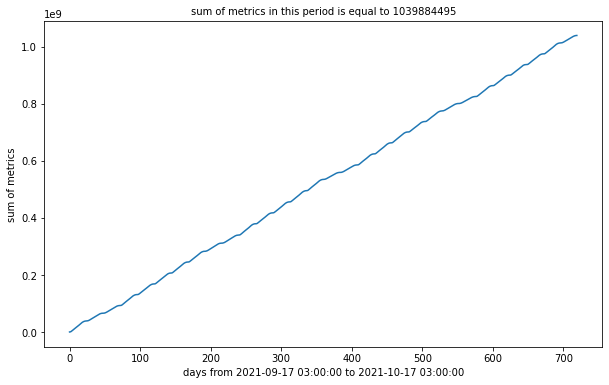

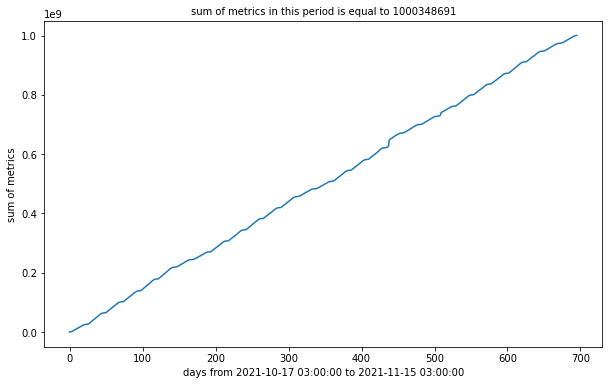

In [32]:
for i in range(len(date_month)):
    if i == 13:
        break
        
    val = 0
    x = []    
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month[i]) & (df['from'] < date_month[i+1])]
    X = list(X)
    
    for j in range(len(X)):
        val += X[j]
        x.append(val)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), x)
    plt.xlabel(f"days from {date_month[i]} to {date_month[i+1]}", fontsize = 10)
    plt.ylabel(f"sum of metrics", fontsize = 10)
    plt.title(f"sum of metrics in this period is equal to {x[len(x)-1]}", fontsize = 10)
    
    plt.show()

##### 2 вариант

1) Также создадим список с нужными датами

In [33]:
import matplotlib.ticker as mticker

date_month_v2 = []

date_month_v2.append(datetime.fromisoformat('2020-10-17 03:00:00'))

for i in range(len(date_list)):
    if date_list[i].strftime('%d%H') == '0100':
        date_month_v2.append(date_list[i])

date_month_v2.append(datetime.fromisoformat('2021-11-15 03:00:00'))

date_month_v2

[datetime.datetime(2020, 10, 17, 3, 0),
 datetime.datetime(2020, 11, 1, 0, 0),
 datetime.datetime(2020, 12, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 2, 1, 0, 0),
 datetime.datetime(2021, 3, 1, 0, 0),
 datetime.datetime(2021, 4, 1, 0, 0),
 datetime.datetime(2021, 5, 1, 0, 0),
 datetime.datetime(2021, 6, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 11, 1, 0, 0),
 datetime.datetime(2021, 11, 15, 3, 0)]

2) посмтроим графики, где будет показано количество метрик за каждый час

NameError: name 'y' is not defined

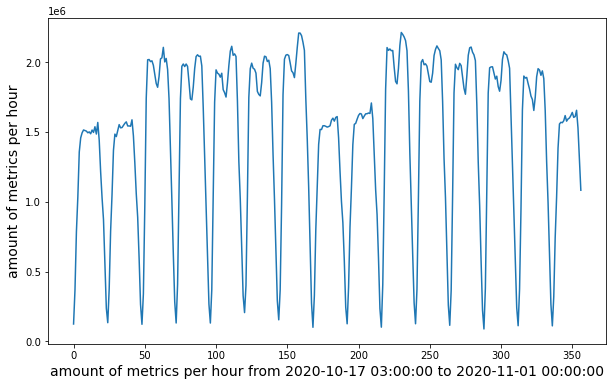

In [34]:
for i in range(len(date_month_v2)):
    if i == 14:
        break
        
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month_v2[i]) & (df['from'] < date_month_v2[i+1])]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), X)
    plt.xlabel(f"amount of metrics per hour from {date_month_v2[i]} to {date_month_v2[i+1]}", fontsize = 14)
    plt.ylabel(f"amount of metrics per hour", fontsize = 14)
    plt.title(f"max metrics per hour = {max(y)} | min metrics per hour = {min(y)}", fontsize = 14)

    plt.show()

3) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик в этом месяце

In [ ]:
for i in range(len(date_month)):
    if i == 14:
        break
        
    a = range(0, 745, 24)    
    day_metrics = []
    day_val = 0
    val = 0
    x = []    
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month_v2[i]) & (df['from'] < date_month_v2[i+1])]
    X = list(X)
    
    for j in range(len(X)):
        val += X[j]
        x.append(val)
        
    for g in range(len(x)):    
        day_val += X[g]
        if g in a:
            day_metrics.append(day_val)
            day_val = 0
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), x)
    plt.xlabel(f"days from {date_month_v2[i]} to {date_month_v2[i+1]}", fontsize = 10)
    plt.ylabel(f"sum of metrics", fontsize = 10)
    plt.title(f"sum of metrics in this period is equal to {x[len(x)-1]}", fontsize = 10)
    
    print(f"max = {max(day_metrics)} in day {day_metrics.index(max(day_metrics)) + 1}, min = {min(day_metrics)} in day {day_metrics.index(min(day_metrics)) + 1}")
    
    plt.show()